In [1]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [2]:
file_path = '../Features/rabbit_B_SHAP_KNN2.xlsx'
df = pd.read_excel(file_path)
df.head()

,FractionCSP3,fr_aldehyde,Chi1,PEOE_VSA13,MaxEStateIndex,FpDensityMorgan2,MaxAbsEStateIndex,qed,FpDensityMorgan3,fr_methoxy,EState_VSA2,AvgIpc,MinAbsPartialCharge,Irritation
0,1.000000,0,0.888614,0.0,0.717468,0.007027,0.717468,0.100715,0.005584,0.0,0.000000,0.828191,0.186733,0
1,0.344828,0,0.462399,0.0,0.883389,0.456948,0.883389,0.536107,0.512357,0.0,0.065012,0.717672,0.236730,0
2,0.363636,0,0.347014,0.0,0.802780,0.539576,0.802780,0.725800,0.618976,0.0,0.250016,0.756701,0.311227,1
3,0.733333,0,0.202972,0.0,0.618649,0.721014,0.618649,0.755228,0.703317,0.0,0.186368,0.598758,0.059691,1
4,0.052632,0,0.289542,0.0,0.371470,0.231884,0.371470,0.583083,0.307125,0.0,0.065130,0.631675,0.033954,0


In [3]:
print(df.columns.to_list())

['FractionCSP3', 'fr_aldehyde', 'Chi1', 'PEOE_VSA13', 'MaxEStateIndex', 'FpDensityMorgan2', 'MaxAbsEStateIndex', 'qed', 'FpDensityMorgan3', 'fr_methoxy', 'EState_VSA2', 'AvgIpc', 'MinAbsPartialCharge', 'Irritation']


In [4]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  
y = df['Irritation']

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=5)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 562 samples
Test set: 141 samples


In [6]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 50),  # Wider range
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "chebyshev", "minkowski"]),
        "algorithm": trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "p": trial.suggest_int("p", 1, 5),  # More flexibility for Minkowski

    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = KNeighborsClassifier(**param) 
        model.fit(X_train_cv, y_train_cv)
 
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-05-11 18:54:45,951] A new study created in memory with name: no-name-bfcd8ff5-deac-4524-8350-112f4f523a60
[I 2025-05-11 18:54:45,997] Trial 0 finished with value: 0.7526548672566371 and parameters: {'n_neighbors': 36, 'metric': 'euclidean', 'algorithm': 'ball_tree', 'p': 5}. Best is trial 0 with value: 0.7526548672566371.
[I 2025-05-11 18:54:46,454] Trial 1 finished with value: 0.7401706700379267 and parameters: {'n_neighbors': 43, 'metric': 'minkowski', 'algorithm': 'brute', 'p': 5}. Best is trial 0 with value: 0.7526548672566371.
[I 2025-05-11 18:54:46,536] Trial 2 finished with value: 0.7597977243994943 and parameters: {'n_neighbors': 13, 'metric': 'manhattan', 'algorithm': 'kd_tree', 'p': 3}. Best is trial 2 with value: 0.7597977243994943.
[I 2025-05-11 18:54:46,691] Trial 3 finished with value: 0.7313527180783818 and parameters: {'n_neighbors': 5, 'metric': 'minkowski', 'algorithm': 'ball_tree', 'p': 5}. Best is trial 2 with value: 0.7597977243994943.
[I 2025-05-11 18:54:4

Best trial: {'n_neighbors': 13, 'metric': 'manhattan', 'algorithm': 'kd_tree', 'p': 3}
Final Model Accuracy: 0.8156028368794326


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Initialize the KNN model with best parameters
final_model = KNeighborsClassifier(**best_params)

# Fit the model on the training data
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Train Accuracy: 0.7722419928825622
Test Accuracy: 0.8297872340425532
Precision: 0.7831325301204819
Recall: 0.9154929577464789
F1 Score: 0.8441558441558441


In [8]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)


base_knn = KNeighborsClassifier(**best_params)
calibrated_knn = CalibratedClassifierCV(base_knn, method='sigmoid', cv=5)


calibrated_knn.fit(X_train, y_train)


y_pred = calibrated_knn.predict(X_test)

test_accuracy = calibrated_knn.score(X_test, y_test)
train_accuracy = calibrated_knn.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


y_proba = calibrated_knn.predict_proba(X_test)


Train Accuracy: 0.806049822064057
Test Accuracy: 0.7446808510638298
Precision: 0.7397260273972602
Recall: 0.7605633802816901
F1 Score: 0.75


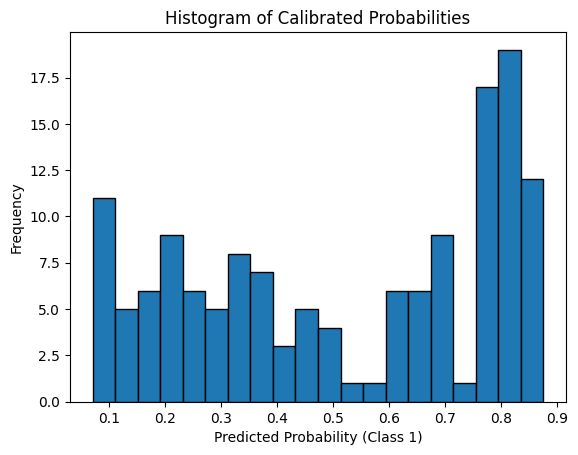

In [9]:
plt.hist(y_proba[:, 1], bins=20, edgecolor='black')
plt.title("Histogram of Calibrated Probabilities")
plt.xlabel("Predicted Probability (Class 1)")
plt.ylabel("Frequency")
plt.show()


In [10]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    final_model = KNeighborsClassifier(**best_params)


    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.7955516014234875 0.7560283687943262


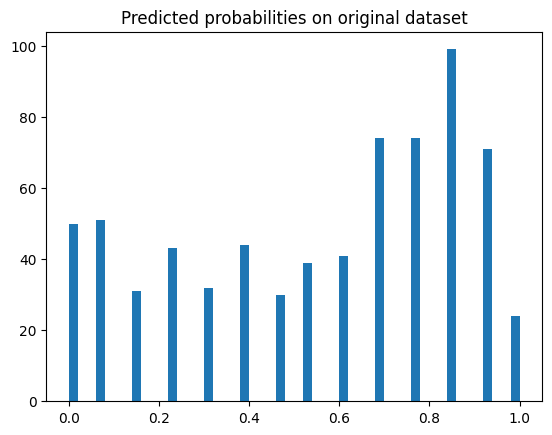

In [11]:
import matplotlib.pyplot as plt

probs = final_model.predict_proba(X)[:, 1]
plt.hist(probs, bins=50)
plt.title("Predicted probabilities on original dataset")
plt.show()


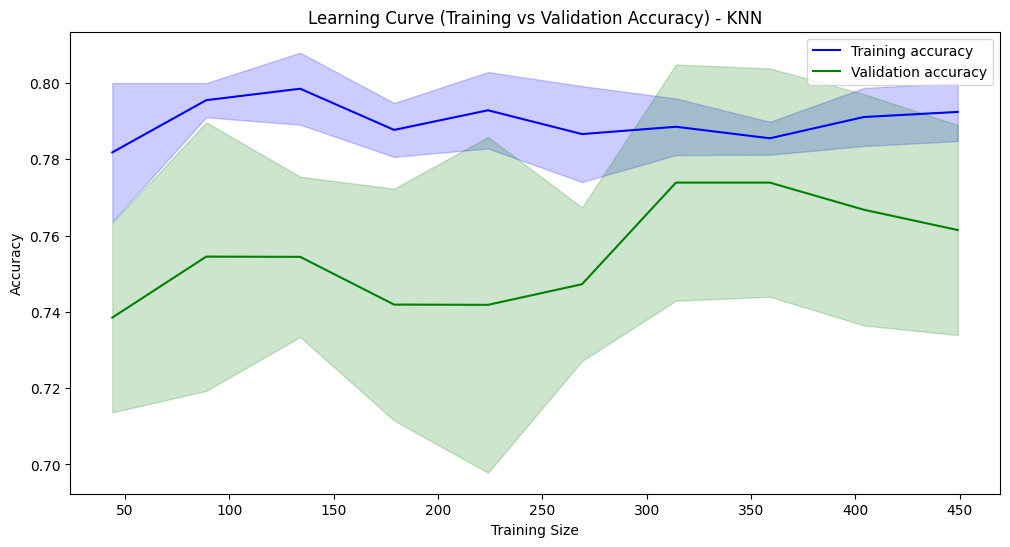

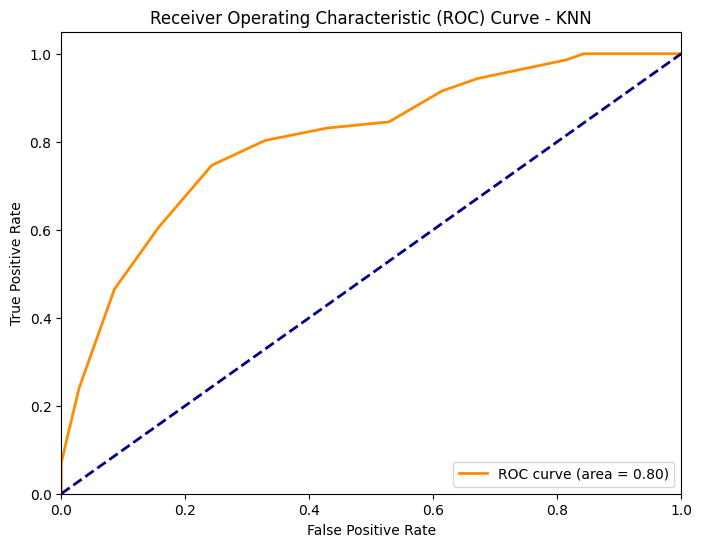

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params

# Initialize the KNN model with best parameters
final_model = KNeighborsClassifier(**best_params)

# Fit the model on the training data
final_model.fit(X_train, y_train)


# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - KNN')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc='lower right')
plt.show()


In [13]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 562 samples
Test set: 141 samples


Best k based on test accuracy: 16
Best Training Accuracy: 0.7972
Best Testing Accuracy: 0.7447
Best k based on bias-variance tradeoff: 45


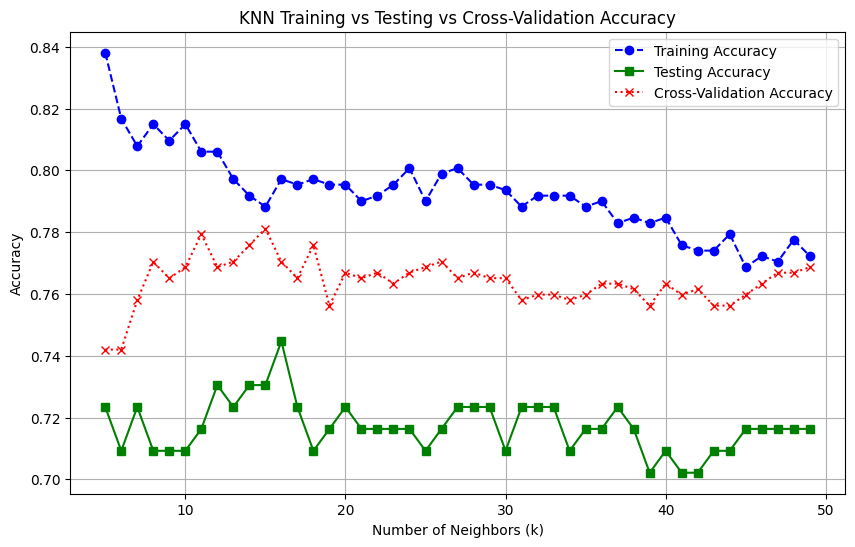

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Define range of k values
k_values = range(5, 50)
train_accuracies = []
test_accuracies = []
cv_accuracies = []

# Iterate over different k values
best_k = 1
best_test_acc = 0
best_train_acc = 0
best_tradeoff_k = 1
best_tradeoff_value = float('inf')

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)  # Train the model
    
    # Compute training and test accuracy
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Perform cross-validation (5-fold)
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    cv_accuracies.append(cv_acc)
    
    # Track best k based on test accuracy
    if test_acc > best_test_acc:
        best_k = k
        best_test_acc = test_acc
        best_train_acc = train_acc
    
    # Find the best tradeoff between bias and variance
    tradeoff_value = abs(train_acc - test_acc)
    if tradeoff_value < best_tradeoff_value:
        best_tradeoff_value = tradeoff_value
        best_tradeoff_k = k

# Print best k and corresponding accuracy
print(f"Best k based on test accuracy: {best_k}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Testing Accuracy: {best_test_acc:.4f}")
print(f"Best k based on bias-variance tradeoff: {best_tradeoff_k}")

# Plot training vs testing vs cross-validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o', linestyle='dashed', color='blue')
plt.plot(k_values, test_accuracies, label='Testing Accuracy', marker='s', linestyle='solid', color='green')
plt.plot(k_values, cv_accuracies, label='Cross-Validation Accuracy', marker='x', linestyle='dotted', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Training vs Testing vs Cross-Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [15]:
background_summary = shap.sample(X_train, 50)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(final_model.predict_proba, background_summary)

# Reduce number of samples to explain 
X_sample = shap.sample(X_test, 500)

# Compute SHAP values with fewer samples (set nsamples lower for faster results)
shap_values = explainer.shap_values(X_sample, nsamples=100)

  0%|          | 0/141 [00:00<?, ?it/s]

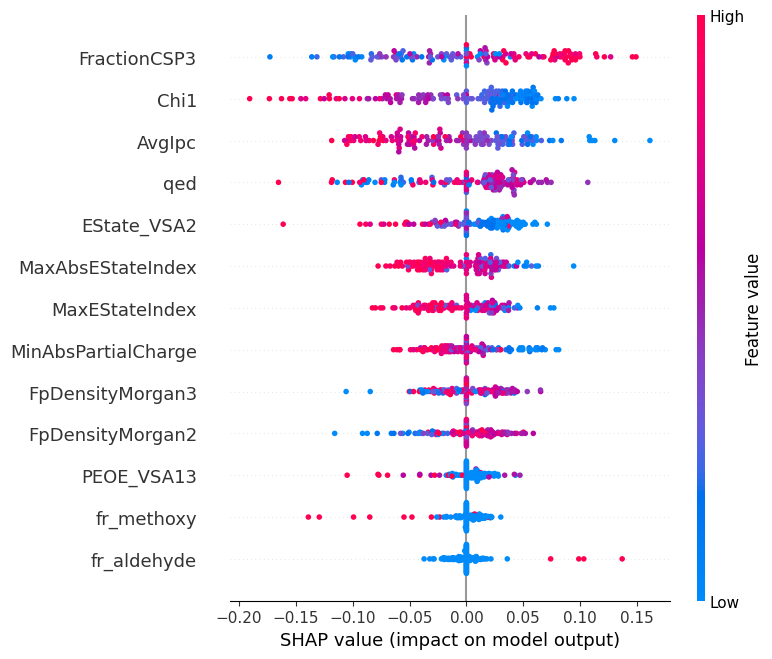

In [16]:
# Plot summary
shap.summary_plot(shap_values[:,:,1], X_sample)

In [17]:
import joblib

joblib.dump(final_model, 'knn_model2.pkl')

print("Model saved successfully!")


Model saved successfully!
